### load funcs and packages

In [127]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy
from sklearn.decomposition import PCA
import os
import sys
from scipy.stats import pearsonr
os.chdir('/projects/sccn/weili_A1/liacz/Documents/Bilingualism_CVAE')
sys.path.append('/projects/sccn/weili_A1/liacz/Documents/Bilingualism_CVAE/misc')
from helper_funcs import *
import statsmodels.api as sm
import seaborn as sns


In [128]:
def data2cmat(data):
    return np.array([squareform(pdist(data[s,:,:],metric='euclidean')) for s in range(data.shape[0])])

# Bar plot function
def plot_nice_bar(key,rsa,ax=None,figsize=None,dpi=None,fontsize=None,fontsize_star=None,fontweight=None,line_width=None,marker_size=None,title=None,report_t=False,do_pairwise_stars=False,do_one_sample_stars=True):
    
    import seaborn as sns
    from scipy.stats import ttest_1samp
    from scipy.stats import ttest_ind as ttest
    
    pallete = sns.color_palette()
    pallete_new = sns.color_palette()
    
    if not figsize:
        figsize = (5,2)
    if not dpi:
        dpi = 300
        
    if not ax:
        fig, ax = plt.subplots(1,1,figsize=figsize,dpi=dpi)

    pallete_new[1]=pallete[0]
    pallete_new[0]=pallete[1]
    pallete_new[0] = tuple(np.array((.5,.5,.5)))

    data=rsa[key]
    n = data.shape[0]
    c = data.shape[1]
    x = np.arange(c)
    
    if not fontsize:
        fontsize = 16
        
    if not fontsize_star:
        fontsize_star = 25
    if not fontweight:        
        fontweight = 'bold'
    if not line_width:    
        line_width = 2.5
    if not marker_size:            
        marker_size = .1
    


    for i in range(c):
        plot_data = np.zeros(data.shape)
        plot_data[:,i] = data[:,i]

        xs = np.repeat(i,n)+(np.random.rand(n)-.5)*.25
        sc = plt.scatter(xs,data[:,i],c='k',s = marker_size)
        b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((np.array(pallete_new[i]),.3)),edgecolor=np.hstack((np.array(pallete_new[i]),1)))

    locs, labels = plt.yticks()  
    new_y = locs
    new_y = np.linspace(locs[0],locs[-1],6)
    plt.yticks(new_y,labels=[f'{yy:.2f}' for yy in new_y],fontsize=fontsize,fontweight=fontweight)
    plt.ylabel('model fit (r)',fontsize=fontsize,fontweight=fontweight)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(line_width)

    xlbls = ['VAE','BG','SL']
    plt.xticks(np.arange(3),labels=xlbls,fontsize=fontsize,fontweight=fontweight)
    
    if do_one_sample_stars:
        one_sample = np.array([ttest_1samp(data[:,i],0) for i in range(3)])
        one_sample_thresh = np.array((1,.05,.001,.0001))
        one_sample_stars = np.array(('n.s.','*','**','***'))
        xlbls = ['VAE','BG','SL']
        for i in range(c):
            these_stars = one_sample_stars[max(np.nonzero(one_sample[i,1]<one_sample_thresh)[0])]
            xlbls[i] = f'{xlbls[i]}\n({these_stars})'
        plt.xticks(np.arange(3),labels=xlbls,fontsize=fontsize,fontweight=fontweight,horizontalalignment='center',multialignment='center')

    pairwise_t = np.zeros((3,3))
    pairwise_p = np.zeros((3,3))

    pairwise_sample_thresh = np.array((1,.05,.001,.0001))
    pairwise_sample_stars = np.array(('n.s.','*','**','***'))

    if report_t:
        for i in range(c):
            for j in range(c):
                t,p = ttest(data[:,i],data[:,j])
                mnames = ['VAE','BG','SL']

                if p > .001:
                    print(f'{key} {mnames[i]} >  {mnames[j]} | t({data.shape[0]-1}) = {t:.2f} p = {p:.2f}')
                else:
                    print(f'{key} {mnames[i]} >  {mnames[j]} | t({data.shape[0]-1}) = {t:.2f} p $<$ .001')
                pairwise_t[i,j] = t
                pairwise_p[i,j] = p

    comps = [[1,2]]
    if do_pairwise_stars:
        for comp_idx in range(len(comps)):
            this_comp = comps[comp_idx]
            sig_idx = max(np.nonzero(pairwise_p[this_comp[0],this_comp[1]]<pairwise_sample_thresh)[0])
            max_y = new_y[-1] + comp_idx*.05
            xs = np.array(this_comp)
            stars = pairwise_sample_stars[sig_idx]
            plt.plot(xs,[max_y,max_y],'k',linewidth=line_width)
            plt.text(xs.mean(),max_y,stars,fontsize=fontsize_star,horizontalalignment='center',fontweight=fontweight)
        
#     ylim = plt.ylim()
#     plt.ylim(np.array(ylim)*(1,1.1))
    plt.ylim(-0.1, 0.16)
    plt.yticks([-0.1,-0.05, 0, 0.05, 0.1, 0.15], ['-0.1','-0.05', '0', '0.05', '0.1', '0.15'])
    
    if not title:
        plt.title(key,fontsize=fontsize*1.5,pad=2,fontweight=fontweight)    
    else:
        plt.title(title,fontsize=fontsize*1.5,pad=2,fontweight=fontweight)

def make_RDM(inVec, data_scale='ratio', metric='euclidean'):
    vec = inVec
    def fun(u,v):
        const = 0 if u[0] == v[0] else 1
        return np.sqrt(const**2)
    if data_scale=='ratio':
        vec = (vec - min(vec.flatten())) / (max(vec.flatten())-min(vec.flatten()))
    
    if np.ndim(inVec)==1: # must be at least 2D
        vec = np.vstack((vec,np.zeros(vec.shape))).transpose()
    if data_scale=='ordinal':
        mat = squareform(pdist(vec, fun).transpose())
#         mat[mat!=0]=1 # Make into zeros and ones
    if data_scale=='ratio':
        mat = squareform(pdist(vec,metric=metric).transpose())
    return mat

def slice_cmat(data,idx):
#     mat = data[patients,:][:,patients]
    mat = data[idx,:][:,idx]
    return mat

def fit_rsa(data,key):
    corr = scipy.stats.stats.kendalltau
    r = np.array([corr(get_triu(slice_cmat(data[i,:,:],model_idxs[key])),get_triu(model_rdms[key]))[0] for i in range(10)])
    r = np.arctan(r)
    return r

### get the latent vectors and behavioral data

In [133]:
exp = '8b2aa1f'

In [ ]:
# from datetime import datetime
# print(datetime.fromtimestamp(os.path.getmtime('data/tf_outputs/CVAE')))

In [134]:
salient_vec_BRAIN = np.load(f'data/latent_vecs/{exp}/latent_vecs10_s.npz')['salient_vec_BRAIN']
background_vec_BRAIN = np.load(f'data/latent_vecs/{exp}/latent_vecs10_z.npz')['background_vec_BRAIN']
vae_vec_BRAIN = np.load(f'data/latent_vecs/{exp}/latent_vecs10_vae.npz')['vae_vec_BRAIN']
print(len(salient_vec_BRAIN))
print(len(background_vec_BRAIN))
print(len(vae_vec_BRAIN))

10
10
10


In [135]:
print(salient_vec_BRAIN.shape)
print(background_vec_BRAIN.shape)
print(vae_vec_BRAIN.shape)

(10, 1655, 16)
(10, 1655, 16)
(10, 1655, 32)


In [136]:
# Make (dis)similarity matrices
cmat_salient_vec_BRAIN = data2cmat(salient_vec_BRAIN)
cmat_background_vec_BRAIN = data2cmat(background_vec_BRAIN)
cmat_vae_vec_BRAIN = data2cmat(vae_vec_BRAIN)

In [137]:
cmat_salient_vec_BRAIN.shape

(10, 1655, 1655)

In [138]:
df = pd.read_csv(os.path.expanduser('data/legend.csv'))
len(df)

455

In [140]:
df['scanner'].value_counts()

scanner
Hernandez    363
Erlangen      92
Name: count, dtype: int64

In [141]:
indir = 'data/array_brains'
BRAIN_data = np.load(os.path.join(indir, f"arr_combine/{exp}/BRAIN_data.npy"))
BRAIN_subs = np.load(os.path.join(indir, f"arr_combine/{exp}/BRAIN_subs.npy"))
BRAIN_ds = np.load(os.path.join(indir, f"arr_combine/{exp}/BRAIN_ds.npy"))
legend_subs= df['ds_par_id']
BRAIN_ds_subs = [BRAIN_ds[i]+'_'+BRAIN_subs[i] for i in range(0,len(BRAIN_subs))]

BRAIN_subs.shape

(1655,)

In [142]:
BRAIN_ds_subs_pd = pd.DataFrame(BRAIN_ds_subs, columns = ['ds_par_id'])
BRAIN_ds_subs_pd['index'] = range(len(BRAIN_ds_subs_pd.iloc[:,0]))
BRAIN_ds_subs_pd

,ds_par_id,index
0,Hernandez_WL_052.mgz,0
1,Hernandez_271ES.mgz,1
2,Hernandez_PI_028.mgz,2
3,Hernandez_71_E.mgz,3
4,Hernandez_WL_002.mgz,4
...,...,...
1650,HCPdev_HCD2055237_V1_MR,1650
1651,HCPdev_HCD0232223_V1_MR,1651
1652,HCPdev_HCD0392649_V1_MR,1652
1653,HCPdev_HCD0197348_V1_MR,1653


In [143]:
df_sort = pd.merge(df, BRAIN_ds_subs_pd, how = 'right', on ='ds_par_id').sort_values(by=['index'])
df_sort.drop_duplicates(inplace=True)
#filter rows with NaN in participant_id
df_sort = df_sort[df_sort['participant_id'].notna()]

df_sort['bilingualism']=pd.to_numeric(df_sort.bilingualism)
df_sort['num_lan']=pd.to_numeric(df_sort.num_lan)
df_sort['age']=pd.to_numeric(df_sort.age)
df_sort['aoa']=pd.to_numeric(df_sort.aoa)
df_sort['sec_lan_proficiency']=pd.to_numeric(df_sort.sec_lan_proficiency)
# df_sort['sec_lan_exposure']=pd.to_numeric(df_sort.sec_lan_exposure)


### variables relationships

In [146]:
df_sort['weaker_lan_proficiency'] = df_sort[['sec_lan_proficiency', 'fst_lan_proficiency']].min(axis=1)

In [147]:
df_sort

,participant_id,bilingualism,age,sex,aoa_group,num_lan,sec_lan_proficiency,ds,scanner,aoa,fst_lan_proficiency,ds_par_id,index,weaker_lan_proficiency
0,WL_052.mgz,0.0,24.0,F,NaN,NaN,0.734720,Hernandez,Hernandez,NaN,NaN,Hernandez_WL_052.mgz,0,0.734720
1,271ES.mgz,1.0,20.0,M,EB,NaN,0.704174,Hernandez,Hernandez,5.0,0.650000,Hernandez_271ES.mgz,1,0.650000
2,PI_028.mgz,1.0,22.0,F,LB,NaN,0.746276,Hernandez,Hernandez,8.0,0.884184,Hernandez_PI_028.mgz,2,0.746276
3,71_E.mgz,1.0,22.0,F,EB,NaN,0.576271,Hernandez,Hernandez,4.0,0.500000,Hernandez_71_E.mgz,3,0.500000
4,WL_002.mgz,0.0,20.0,F,NaN,NaN,0.758346,Hernandez,Hernandez,NaN,NaN,Hernandez_WL_002.mgz,4,0.758346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,JV.mgz,1.0,39.0,M,LB,NaN,0.670599,Hernandez,Hernandez,22.0,0.784729,Hernandez_JV.mgz,355,0.670599
356,Sub38FS.mgz,1.0,25.0,F,EB,NaN,0.803801,Hernandez,Hernandez,6.0,0.796440,Hernandez_Sub38FS.mgz,356,0.796440
357,PI_071.mgz,1.0,23.0,M,EB,NaN,0.878274,Hernandez,Hernandez,1.0,0.768319,Hernandez_PI_071.mgz,357,0.768319
358,271DT.mgz,1.0,20.0,M,EB,NaN,0.709165,Hernandez,Hernandez,3.5,0.561330,Hernandez_271DT.mgz,358,0.561330


In [149]:
pred = df_sort[['fst_lan_proficiency', 'sec_lan_proficiency', 'weaker_lan_proficiency', 'aoa','age']]
pred['sex'] = df_sort['sex'].astype('category').cat.codes
rho = pred.corr()
pval = pred.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

/tmp/ipykernel_2853597/442878106.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred['sex'] = df_sort['sex'].astype('category').cat.codes
/tmp/ipykernel_2853597/442878106.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))


,fst_lan_proficiency,sec_lan_proficiency,weaker_lan_proficiency,aoa,age,sex
fst_lan_proficiency,1.0***,0.24***,0.78***,0.4***,0.32***,0.23***
sec_lan_proficiency,0.24***,1.0***,0.81***,-0.37***,-0.01,-0.05
weaker_lan_proficiency,0.78***,0.81***,1.0***,-0.01,0.07,0.04
aoa,0.4***,-0.37***,-0.01,1.0***,0.54***,0.18**
age,0.32***,-0.01,0.07,0.54***,1.0***,0.1
sex,0.23***,-0.05,0.04,0.18**,0.1,1.0***


### get rsa results

In [ ]:
# df_sort = df_sort.loc[df_sort.ds == 'Hernandez']
# df_sort = df_sort.loc[df_sort.bilingualism == 1]

In [150]:
df_sort.aoa_group.value_counts()
# #map EB as 1
# #map LB as 2
# df_sort['aoa_group'] = df_sort['aoa_group'].apply(lambda x: 1 if x == 'EB' else 2)

aoa_group
EB    134
LB     81
Name: count, dtype: int64

In [153]:
patients = df_sort['bilingualism'].values==1.0
controls = df_sort['bilingualism'].values==0.0

# BRAIN MAKE MODELS 
# plt.figure(figsize=(15,15))
# default_keys = ['sec_lan_proficiency','sec_lan_exposure', 'aoa', 'aoa_group',  'age','sex', 'scanner']
default_keys = ['sec_lan_proficiency','fst_lan_proficiency', 'weaker_lan_proficiency', 'aoa_group', 'aoa', 'age',  'sex']
# default_keys = ['sec_lan_proficiency','aoa', 'aoa_group', 'age',  'sex']
scales_ = ['ratio','ratio','ratio','ordinal', 'ratio', 'ratio', 'ordinal']


# default_keys = ['age', 'sex', 'scanner']

# scales_ = ['ratio', 'ordinal','ordinal']
# scales_ = ['ratio','ratio','ratio', 'ordinal','ratio','ordinal','ordinal']
# scales_ = ['ratio', 'ratio','ratio', 'ordinal','ordinal']



model_rdms = dict()
model_idxs = dict()
for i in range(len(default_keys)):
    print(default_keys[i])
    inVec = df_sort[default_keys[i]].values[patients]
    idx_all = df_sort['index'].values[patients]
#     inVec = df_sort[default_keys[i]].to_numpy() 
#     idx_all = df_sort['index'].to_numpy() 
    idx = idx_all[~pd.isna(inVec)]
    inVec = inVec[~pd.isna(inVec)]
    this_rdm = make_RDM(inVec, data_scale=scales_[i])
#     print(len(idx))
    model_rdms.update({default_keys[i] : this_rdm})
    model_idxs.update({default_keys[i] : idx})

sec_lan_proficiency
fst_lan_proficiency
weaker_lan_proficiency
aoa_group
aoa
age
sex


In [154]:
data = [cmat_vae_vec_BRAIN, cmat_background_vec_BRAIN, cmat_salient_vec_BRAIN]

rsa_results = dict()
for key in default_keys:
    print(key)
    res = np.array([fit_rsa(datum,key) for datum in data]).transpose()
    rsa_results.update({key : res})

sec_lan_proficiency
fst_lan_proficiency


/tmp/ipykernel_2853597/1255011879.py:142: DeprecationWarning: Please import `kendalltau` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  corr = scipy.stats.stats.kendalltau


weaker_lan_proficiency
aoa_group
aoa
age
sex


/tmp/ipykernel_2853597/1255011879.py:51: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'r'}` instead.

  b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((np.array(pallete_new[i]),.3)),edgecolor=np.hstack((np.array(pallete_new[i]),1)))
/tmp/ipykernel_2853597/1255011879.py:51: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2.5}` instead.

  b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((np.array(pallete_new[i]),.3)),edgecolor=np.hstack((np.array(pallete_new[i]),1)))
/tmp/ipykernel_2853597/1255011879.py:51: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'r'}` instead.

  b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((

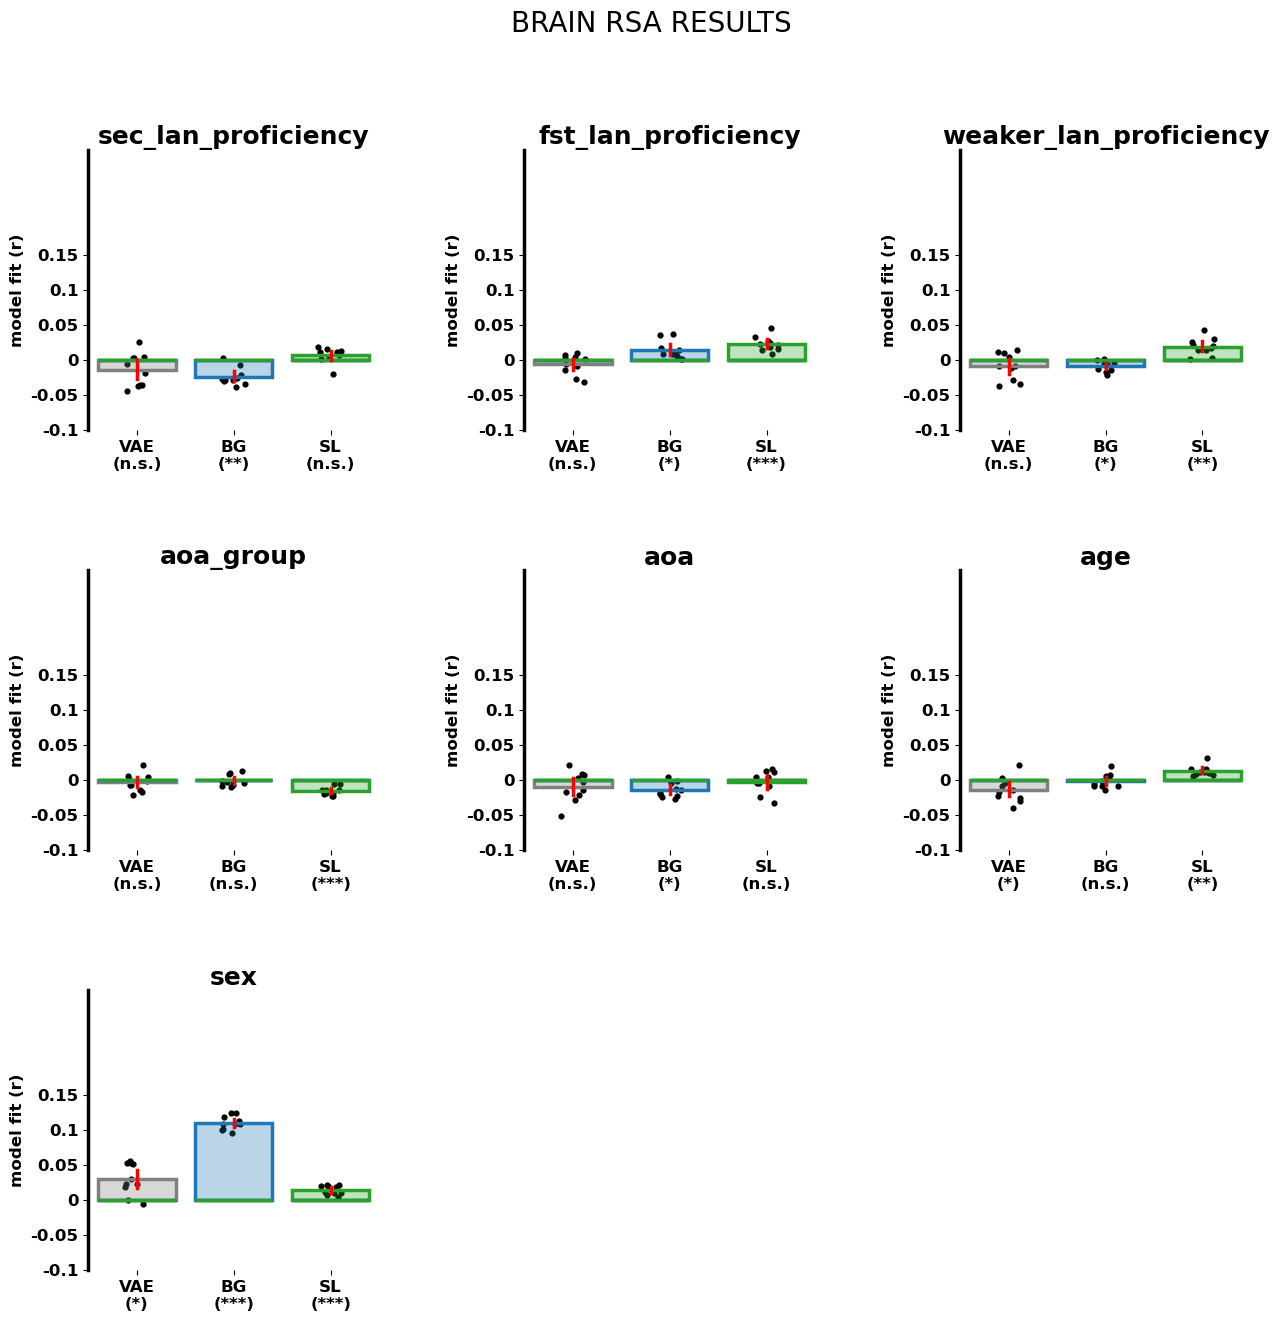

In [155]:
# keys = ['sec_lan_proficiency', 'aoa','aoa_group', 'age','sex','scanner']
# titles = ['sec_lan_proficiency', 'aoa','aoa_group', 'age','sex','dataset']

keys = default_keys
titles = default_keys

# keys = ['sec_lan_proficiency','aoa', 'age','sex', 'scanner']
# titles = ['sec_lan_proficiency','aoa',  'age','sex', 'scanner']


ncols = 3
nrows = int(np.ceil(len(keys)/2))

plt.figure(figsize=np.array((ncols,nrows))*5)

for i, key in enumerate(keys):
    ax = plt.subplot(nrows, ncols, i + 1)
    plot_nice_bar(key, rsa_results,
                  ax=ax, figsize=None,
                  dpi=300, fontsize=12,
                  fontsize_star=12,
                  fontweight='bold',
                  line_width=2.5,
                  marker_size=12, title=titles[i])
    ax.set_ylim(top=0.3) 
    
plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=.5,
    hspace=.5)

plt.suptitle('BRAIN RSA RESULTS',fontsize=20,y=.95);

In [91]:
#only 10 samples, more samples we use, more sensitive -- 10 is the optimal 
# https://www.jstor.org/stable/24700283

### more information about the variables

In [91]:
df_sort.ds.value_counts()

ds
Hernandez    360
Name: count, dtype: int64

In [92]:
df_sort['sex'] = df_sort['sex'].apply(lambda x: 1 if x == 'M' else (2 if x == 'F' else np.nan))
df_sort['aoa_group'] = df_sort['aoa_group'].apply(lambda x: 1 if x == 'EB' else (2 if x == 'LB' else np.nan))
# df_sort['sex'] = df_sort['sex'].astype('category').cat.codes

In [93]:
df_sort.aoa_group.value_counts()

aoa_group
1.0    134
2.0     81
Name: count, dtype: int64

In [94]:
df_sort.sex.value_counts()

sex
2.0    233
1.0     94
Name: count, dtype: int64

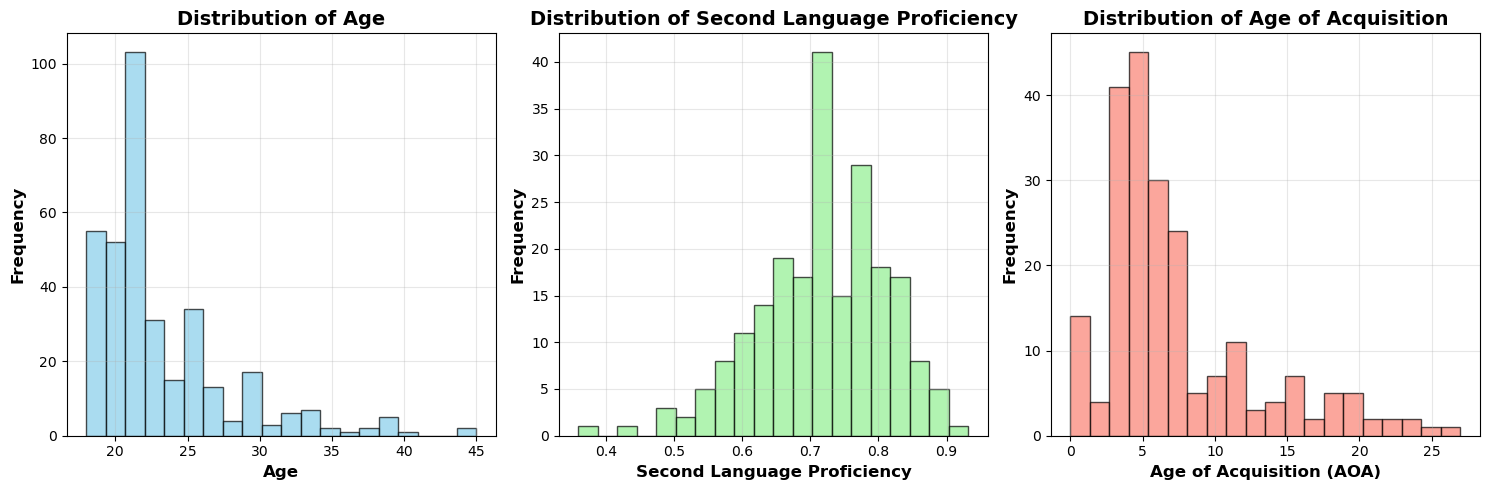

In [39]:
# get the histogram of the age, sec_lan_proficiency, and aoa.
# Get histograms of age, sec_lan_proficiency, and aoa
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Age histogram
axes[0].hist(df_sort['age'].dropna(), bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Age', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Age', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Second language proficiency histogram
axes[1].hist(df_sort['sec_lan_proficiency'].dropna(), bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1].set_xlabel('Second Language Proficiency', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Distribution of Second Language Proficiency', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Age of acquisition histogram
axes[2].hist(df_sort['aoa'].dropna(), bins=20, alpha=0.7, color='salmon', edgecolor='black')
axes[2].set_xlabel('Age of Acquisition (AOA)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[2].set_title('Distribution of Age of Acquisition', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [481]:
# Define the dependent and independent variables
X = df_sort['aoa']
y = df_sort['age']

# Check for and handle missing values
X = X.replace([np.inf, -np.inf], np.nan)
y = y.replace([np.inf, -np.inf], np.nan)

# Drop rows with any NaN values in X or y
df_clean = pd.concat([X, y], axis=1).dropna()
X_clean = df_clean['aoa']
# X_clean['interaction'] = X_clean['sec_lan_proficiency'] * X_clean['aoa']
y_clean = df_clean['age']

# Add a constant to the independent variable (intercept)
X_clean = sm.add_constant(X_clean)

# Fit the linear model
model = sm.OLS(y_clean, X_clean).fit()

# Get the residuals
res = model.resid

# Print or use the residuals as needed
print(res)

# Calculate the mean of residuals ignoring NaN values
mean_residuals = np.nanmean(res)
print("Mean of residuals:", mean_residuals)

# Create a DataFrame for residuals
residuals_df = pd.DataFrame({'age_res': res}, index=df_clean.index)

# Merge residuals back into the original DataFrame
df_sort = df_sort.merge(residuals_df, left_index=True, right_index=True, how='left')

# Print the updated DataFrame
print(df_sort)


ValueError: zero-size array to reduction operation maximum which has no identity

In [482]:
patients = df_sort['bilingualism'].values==1.0
controls = df_sort['bilingualism'].values==0.0

# BRAIN MAKE MODELS 
# plt.figure(figsize=(15,15))
# default_keys = ['sec_lan_proficiency','sec_lan_exposure', 'aoa', 'aoa_group',  'age','sex', 'scanner']
default_keys = ['sec_lan_proficiency', 'aoa_group', 'age',  'sex']
# default_keys = ['sec_lan_proficiency','aoa', 'aoa_group', 'age',  'sex']
scales_ = ['ratio','ratio','ratio', 'ordinal']


# default_keys = ['age', 'sex', 'scanner']

# scales_ = ['ratio', 'ordinal','ordinal']
# scales_ = ['ratio','ratio','ratio', 'ordinal','ratio','ordinal','ordinal']
# scales_ = ['ratio', 'ratio','ratio', 'ordinal','ordinal']



model_rdms = dict()
model_idxs = dict()
for i in range(len(default_keys)):
    print(default_keys[i])
    inVec = df_sort[default_keys[i]].values[patients]
    idx_all = df_sort['index'].values[patients]
#     inVec = df_sort[default_keys[i]].to_numpy() 
#     idx_all = df_sort['index'].to_numpy() 
    idx = idx_all[~pd.isna(inVec)]
    inVec = inVec[~pd.isna(inVec)]
    this_rdm = make_RDM(inVec, data_scale=scales_[i])
#     print(len(idx))
    model_rdms.update({default_keys[i] : this_rdm})
    model_idxs.update({default_keys[i] : idx})

sec_lan_proficiency
aoa_group
age
sex


In [483]:
data = [cmat_vae_vec_BRAIN, cmat_background_vec_BRAIN, cmat_salient_vec_BRAIN]

rsa_results = dict()
for key in default_keys:
    print(key)
    res = np.array([fit_rsa(datum,key) for datum in data]).transpose()
    rsa_results.update({key : res})

sec_lan_proficiency
aoa_group
age
sex


/tmp/ipykernel_1660712/1255011879.py:142: DeprecationWarning: Please import `kendalltau` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  corr = scipy.stats.stats.kendalltau


/tmp/ipykernel_1660712/1255011879.py:51: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'r'}` instead.

  b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((np.array(pallete_new[i]),.3)),edgecolor=np.hstack((np.array(pallete_new[i]),1)))
/tmp/ipykernel_1660712/1255011879.py:51: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2.5}` instead.

  b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((np.array(pallete_new[i]),.3)),edgecolor=np.hstack((np.array(pallete_new[i]),1)))
/tmp/ipykernel_1660712/1255011879.py:51: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'r'}` instead.

  b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((

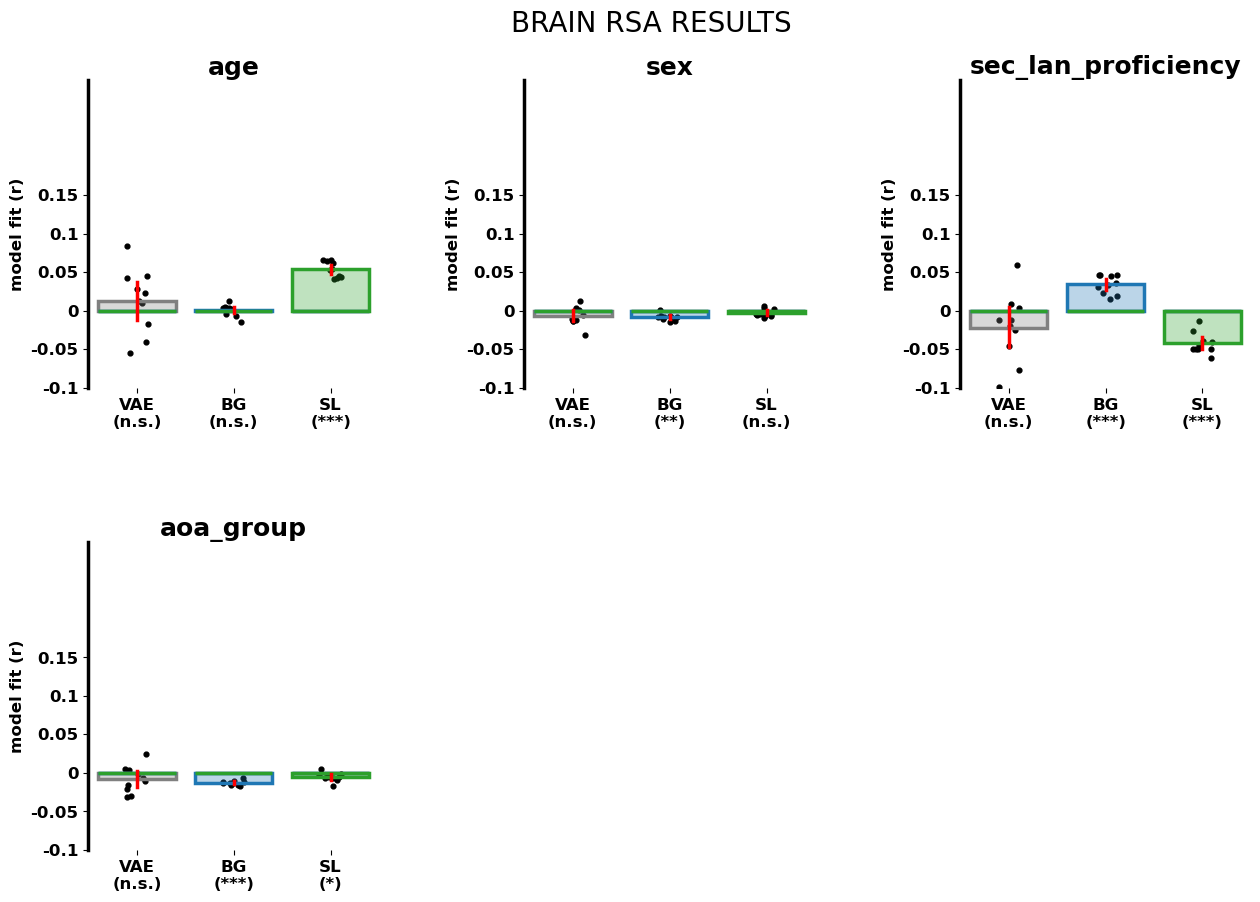

In [484]:
# keys = ['sec_lan_proficiency', 'aoa','aoa_group', 'age','sex','scanner']
# titles = ['sec_lan_proficiency', 'aoa','aoa_group', 'age','sex','dataset']

keys = ['age','sex', 'sec_lan_proficiency', 'aoa_group']
titles = ['age','sex', 'sec_lan_proficiency', 'aoa_group']

# keys = ['sec_lan_proficiency','aoa', 'age','sex', 'scanner']
# titles = ['sec_lan_proficiency','aoa',  'age','sex', 'scanner']


ncols = 3
nrows = int(np.ceil(len(keys)/2))

plt.figure(figsize=np.array((ncols,nrows))*5)

for i, key in enumerate(keys):
    ax = plt.subplot(nrows, ncols, i + 1)
    plot_nice_bar(key, rsa_results,
                  ax=ax, figsize=None,
                  dpi=300, fontsize=12,
                  fontsize_star=12,
                  fontweight='bold',
                  line_width=2.5,
                  marker_size=12, title=titles[i])
    ax.set_ylim(top=0.3) 
    
plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=.5,
    hspace=.5)

plt.suptitle('BRAIN RSA RESULTS',fontsize=20,y=.95);

## analysis

In [316]:
df_sort

,participant_id,bilingualism,age,sex,aoa_group,num_lan,sec_lan_proficiency,ds,scanner,aoa,sec_lan_exposure,ds_par_id,index,residuals
0,WL_052.mgz,0.0,24.0,F,NaN,NaN,NaN,Hernandez,Hernandez,NaN,NaN,Hernandez_WL_052.mgz,0,NaN
1,271ES.mgz,1.0,20.0,M,EB,NaN,0.650000,Hernandez,Hernandez,5.0,NaN,Hernandez_271ES.mgz,1,-1.955946
2,PI_028.mgz,1.0,22.0,F,LB,NaN,0.746276,Hernandez,Hernandez,8.0,NaN,Hernandez_PI_028.mgz,2,-1.817291
3,71_E.mgz,1.0,22.0,F,EB,NaN,0.500000,Hernandez,Hernandez,4.0,NaN,Hernandez_71_E.mgz,3,1.238931
4,WL_002.mgz,0.0,20.0,F,NaN,NaN,NaN,Hernandez,Hernandez,NaN,NaN,Hernandez_WL_002.mgz,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,JV.mgz,1.0,39.0,M,LB,NaN,0.670599,Hernandez,Hernandez,22.0,NaN,Hernandez_JV.mgz,355,9.053984
356,Sub38FS.mgz,1.0,25.0,F,EB,NaN,0.796440,Hernandez,Hernandez,6.0,NaN,Hernandez_Sub38FS.mgz,356,1.866519
357,PI_071.mgz,1.0,23.0,M,EB,NaN,0.768319,Hernandez,Hernandez,1.0,NaN,Hernandez_PI_071.mgz,357,2.324028
358,271DT.mgz,1.0,20.0,M,EB,NaN,0.561330,Hernandez,Hernandez,3.5,NaN,Hernandez_271DT.mgz,358,-0.827809


In [317]:
df_sort.bilingualism.value_counts()

bilingualism
1.0    215
0.0    145
Name: count, dtype: int64

### How does scanner correlate with age, sex, num_lan, and aoa?

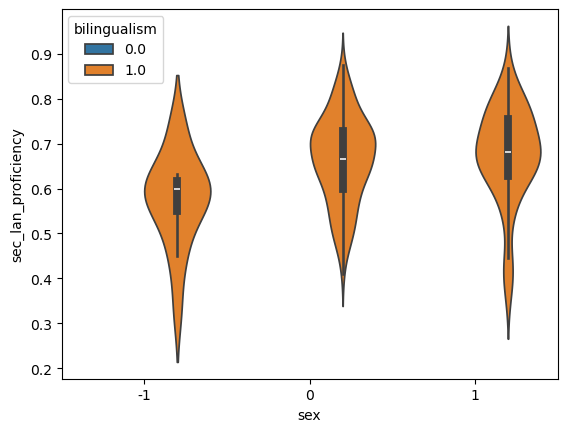

In [414]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.violinplot(x="sex", y="sec_lan_proficiency", hue='bilingualism', data=df_sort)
# plt.xticks(rotation=45)
# plt.bar(df_sort['sex'], df_sort['second_language_proficiency'])
plt.show()

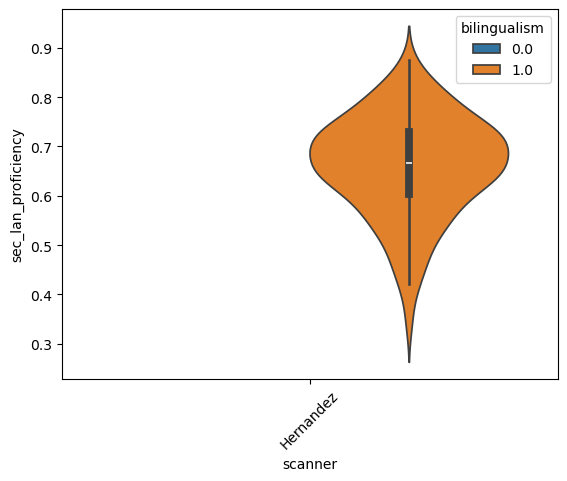

In [319]:
sns.violinplot(x="scanner", y="sec_lan_proficiency", hue='bilingualism', data=df_sort)
plt.xticks(rotation=45)
# plt.bar(df_sort['scanner'], df_sort['age'])
plt.show()

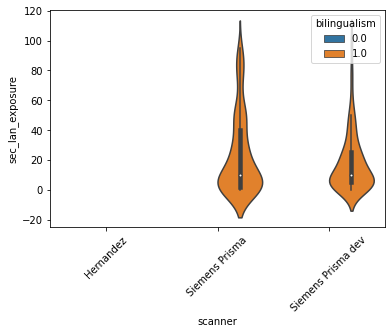

In [25]:
sns.violinplot(x="scanner", y="sec_lan_exposure", hue='bilingualism', data=df_sort)
plt.xticks(rotation=45)
# plt.bar(df_sort['scanner'], df_sort['age'])
plt.show()

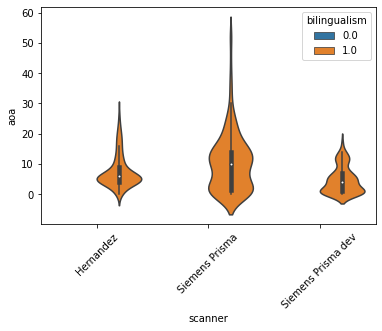

In [26]:
sns.violinplot(x="scanner", y="aoa", hue='bilingualism', data=df_sort)
plt.xticks(rotation=45)
# plt.bar(df_sort['scanner'], df_sort['age'])
plt.show()

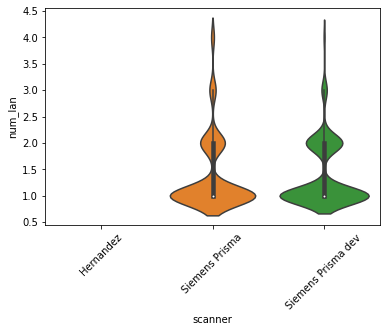

In [27]:
sns.violinplot(x="scanner", y="num_lan", data=df_sort)
plt.xticks(rotation=45)
# plt.bar(df_sort['scanner'], df_sort['age'])
plt.show()

In [28]:
pd.crosstab(df_sort['scanner'], df_sort['sex'])

sex,F,M
scanner,,
Hernandez,233,94
Siemens Prisma,406,318
Siemens Prisma dev,309,262


In [29]:
pd.crosstab(df_sort['scanner'], df_sort['aoa_group'])

aoa_group,EB,LB
scanner,,
Hernandez,134,81
Siemens Prisma,126,75
Siemens Prisma dev,173,12


### aoa and aoa_group

In [320]:
aoa_rdm = model_rdms['aoa']
aoagroup_rdm = model_rdms['aoa_group']

KeyError: 'aoa_group'

In [321]:
common_idx = np.intersect1d(model_idxs['aoa'], model_idxs['aoa_group'])

KeyError: 'aoa_group'

In [38]:
indexes = np.where(np.in1d(model_idxs['aoa_group'], common_idx))[0]

In [39]:
corr = scipy.stats.stats.kendalltau
corr(get_triu(model_rdms['aoa']),get_triu(slice_cmat(model_rdms['aoa_group'], indexes))) 

KendalltauResult(correlation=0.5408876585791225, pvalue=0.0)

### all the predictors correlation

In [ ]:

pred_matrix = pred.corr()

<Axes: >

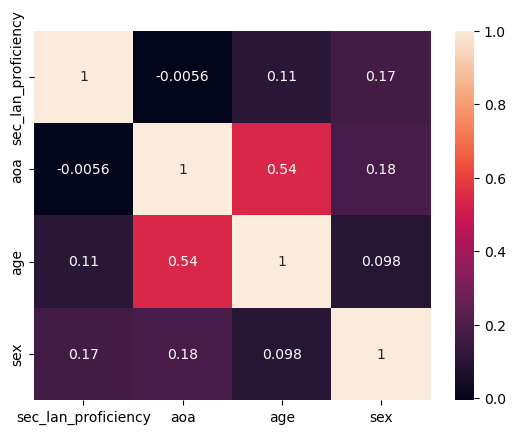

In [329]:
sns.heatmap(pred_matrix, annot=True)

### PCA analysis

In [88]:
len(pred.dropna(subset=['num_lan']))
len(pred.dropna(subset=['sec_lan_exposure']))
len(pred.dropna(subset=['aoa']))
len(pred.dropna(subset=['sec_lan_proficiency']))

pred_drop = pred[['sec_lan_proficiency', 'sec_lan_exposure', 'aoa', 'aoa_group', 'age']].dropna()

In [89]:
from sklearn.decomposition import PCA
pca = PCA()
principalComponents = pca.fit_transform(pred_drop)

In [90]:
pca.explained_variance_ratio_

array([9.03554094e-01, 5.09028636e-02, 4.55264778e-02, 1.26835061e-05,
       3.88081633e-06])

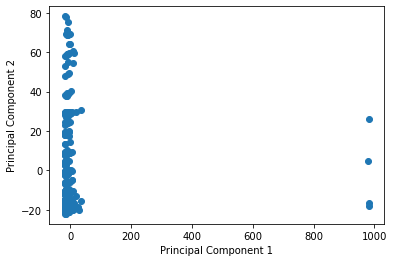

In [91]:
plt.scatter(principalComponents[:, 0], principalComponents[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [5] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


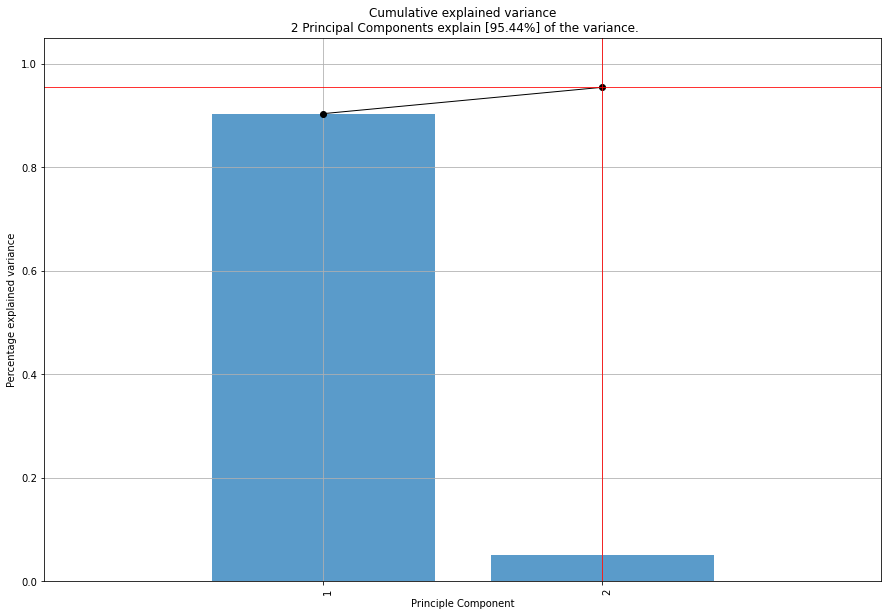

<Figure size 432x288 with 0 Axes>

In [94]:
from pca import pca

# Or reduce the data towards 2 PCs
model = pca(n_components=2)

# Fit transform
results = model.fit_transform(pred_drop)

# Plot explained variance
fig, ax = model.plot()

[pca] >Plotting: 90it [00:00, 894.98it/s]

[pca] >Plot PC1 vs PC2 with loadings.


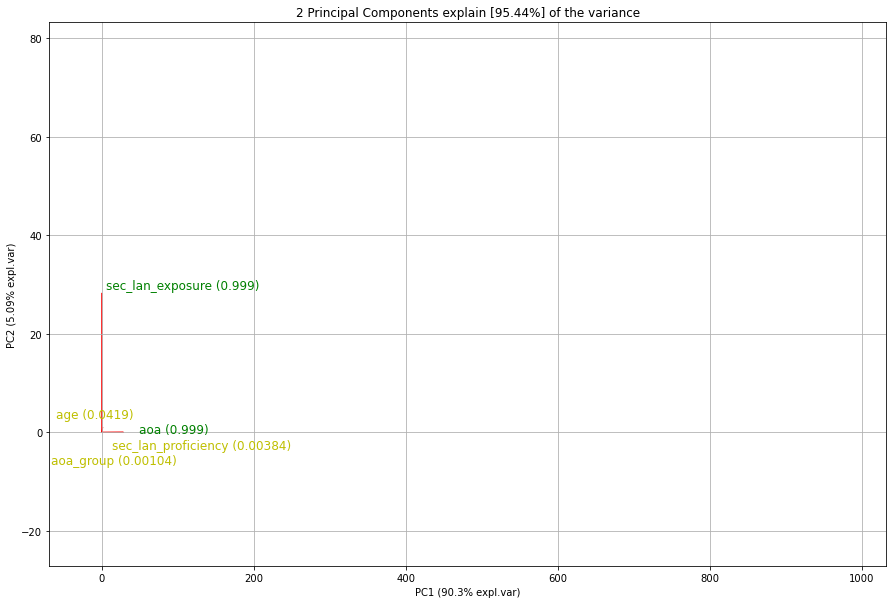

In [102]:
# Make biplot with the number of features
fig, ax = model.biplot(cmap=None, label=False, legend=False, n_feat=5)

<function matplotlib.pyplot.show(*args, **kw)>

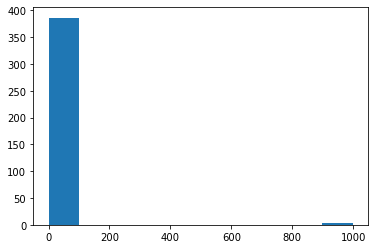

In [103]:
plt.hist(pred.aoa)
plt.show

In [106]:
pred_drop = pred_drop[pred_drop.aoa.values < 200]

<function matplotlib.pyplot.show(*args, **kw)>

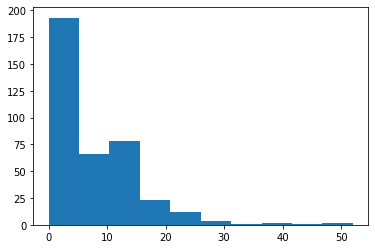

In [107]:
plt.hist(pred_drop.aoa)
plt.show